In [7]:
import sys

if "/home/coberndorm/Documents/Semestre_IX/Artificial_Intelligence" not in sys.path:
  sys.path.append("/home/coberndorm/Documents/Semestre_IX/Artificial_Intelligence/")

In [61]:
from MLP.dataManipulation import *
from MLP.activationFunctions import *
import numpy as np
import matplotlib.pyplot as plt

In [100]:
class Perceptron(object):
    def __init__(self,  num_inputs: int, num_neurons: list, num_outputs: int, func_activation: list, eta = 0.01) -> None:
        """ 
        Initializes the multi-layer perceptron with the specified architecture.

        Args:
        - num_inputs (int): Number of input features.
        - num_neurons (list of int): Number of neurons in each layer.
        - num_output (int): Number of output features.
        - func_activation (list): List of activation functions for each layer.

        """

        # Set the size of the network
        n_layers = [num_inputs] + num_neurons + [num_outputs]
        self.num_layers = len(n_layers)
        self.layers = [0]*self.num_layers
        self.num_neurons = n_layers
        

        # Define all of the layers
        input = num_inputs
        for i, neuron in enumerate(n_layers):
            self.layers[i] = Layer(input, neuron, func_activation[i], eta)
            input = neuron

    def forward(self, input: np.ndarray) -> np.ndarray:
        """
        Performs the forward pass through the neural network.

        Args:
        - input (array): The input data for the forward pass.

        Returns:
        - output (array): The output prediction of the neural network.

        """
        input = input.reshape(-1,1)
        # Iterate through all neurons
        for i in range(self.num_layers):
            input = self.layers[i].forward(input)

        self.output = input
        return self.output
    
    def backward(self, error: np.ndarray) -> list:
        """
        Performs the backward pass to update the network's weights.

        Args:
        - error (array): The error in the prediction.

        Returns:
        - gradients_prom (list of float): List of average gradients for each layer.

        """
        #Initializing an array for the mean of the gradients in every layer
        gradients = [0] * self.num_layers

        # Backpropagation for output layer
        gradients[-1] = self.layers[-1].backward(np.sum(error), 1, True)
        
        # Backpropagation for all the other layers
        for i in reversed(range(self.num_layers - 1)):
            gradients[i] = self.layers[i].backward(self.layers[i + 1].weights, gradients[i+1])

        return gradients

    def train(self, data_x: np.ndarray, data_y: np.ndarray, epochs: int) -> list:
        """
        Trains the neural network on the given data using backpropagation.

        Args:
        - data (array): Input data with the last value the target column.
        - epochs (int): Number of training epochs.

        Returns:
        - gradients (list): List of gradients computed during training.

        """

        # Defining the train and test set
        train_x, test_x, _, idx = train_test_val(data_x, (75,25,0))
        train_y = data_y[idx[0]]; test_y = data_y[idx[1]]
        print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

        # Check Y dimensions are of the size of the output layer
        assert len(train_y[0]) if type(train_y[0])==np.ndarray else 1 == self.num_neurons[-1]

        # Define auxiliary variables
        data_len = len(train_x)
        gradients = [0] * data_len * epochs
        instant_energy_train = [0] * data_len * epochs; instant_average_energy_test = [0]*epochs
        counter = 0

        for epoch in range(epochs):
            for i, stimuli in enumerate(train_x):
              y_pred = self.forward(np.array([stimuli]))
              error = np.array(train_y[i] - y_pred)

              instant_energy_train[counter] = np.sum(error**2)/2
              gradients[counter] = self.backward(error)
              counter += 1
              if  instant_energy_train[counter-1] < 0.01:  
                break
              
            #Test error
            error_test = np.array([test_y[i] - self.forward(x) for i,x in enumerate(test_x)])
            instant_average_energy_test[epoch] = np.mean(error_test**2)/2

            #if instant_average_energy_test[epoch] < 0.01:
            #  break

        return gradients, instant_energy_train, instant_average_energy_test
    
    def train_batch(self, data_x: np.ndarray, data_y: np.ndarray, epochs = 10, iter = 5, num_back = 50) -> list:
        """
        Trains the neural network on the given data using backpropagation.

        Args:
        - data (array): Input data with the last value the target column.
        - epochs (int): Number of training epochs.

        Returns:
        - gradients (list): List of gradients computed during training.

        """

        # Defining the train and test set
        train_x, test_x, _, idx = train_test_val(data_x, (75,25,0))
        train_y = data_y[idx[0]]; test_y = data_y[idx[1]]
        print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

        # Check Y dimensions are of the size of the output layer
        assert len(train_y[0]) if type(train_y[0])==np.ndarray else 1 == self.num_neurons[-1]

        # Define auxiliary variables
        data_len = len(train_x)
        gradients = [0] * data_len * epochs
        instant_energy_train = [0] * data_len * epochs; instant_average_energy_test = [0]*epochs
        counter = 0

        for epoch in range(epochs):
            y_pred = [0]*data_len; error = [0]*data_len
            for i, stimuli in enumerate(train_x):
              y_pred[i] = self.forward(np.array([stimuli]))
              error[i] = np.array(train_y[i] - y_pred[i])

            idx = np.argsort(-np.array(error).flatten())[:num_back]
            for i in idx:
                instant_energy_train[counter] = np.sum(error[i]**2)/2
                self.forward(np.array([train_x[i]]))
                gradients[counter] = self.backward(error[i])
                counter += 1
                if  instant_energy_train[counter-1] < 0.01:  
                    break
              
            #Test error
            error_test = np.array([test_y[i] - self.forward(x) for i,x in enumerate(test_x)])
            instant_average_energy_test[epoch] = np.mean(error_test**2)/2

            #if instant_average_energy_test[epoch] < 0.01:
            #  break

        return gradients, instant_energy_train, instant_average_energy_test

class Layer():
    def __init__(self, num_inputs: int, num_neurons:int, activation: object, eta:float) -> None:
        """
        Initializes a neural network layer.

        Args:
        - n_inputs (int): Number of input features.
        - n_neurons (int): Number of neurons in the layer.
        - activation (Activation): Activation function for the layer.

        """

        # Initialize weights randomly (you can uncomment the random initialization below)
        self.weights = np.random.randn(num_neurons, num_inputs + 1) *2 -1
        #self.weights = np.ones((num_neurons, num_inputs))

        
        # Set Activation function
        self.activation = activation  # Create an instance of the provided activation function
        # Learning rate (you can adjust this)
        self.eta = eta

    def forward(self, input: np.ndarray) -> np.ndarray:
        """
        Performs the forward pass through the layer.

        Args:
        - input (array): The input stimuli for the layer.

        """

        # Save the input input for later use in backward pass
        self.input = input

        # Compute the initial linear combination of input and weights
        self.field = np.matmul(self.weights, np.vstack((self.input,1)))

        # Apply the activation function to the linear combination
        self.output = self.activation.forward(self.field)
        return self.output
    
    def backward(self, weights_prev: np.ndarray, local_gradient_prev: np.ndarray, first = False) -> np.ndarray:
        """
        Performs backpropagation for the layer.

        Args:
        - weights_prev (array): Weights from the next layer.
        - local_gradient_prev (array): Local gradient from the next layer.

        Returns:
        - local_gradient (array): Local gradient for this layer.

        """

        phi_prime = self.activation.backward(self.field)  # Compute the derivative of the activation function

        # Compute local gradient for this layer using chain rule and weights from the next layer
        local_gradient = np.multiply(phi_prime, np.dot(weights_prev[:,:-1].T if not first else weights_prev.T, local_gradient_prev))


        # Compute weight update using the local gradient and input stimuli
        delta = np.dot(local_gradient, np.vstack((self.input,1)).T) # Weight and bias change

        assert delta.shape == self.weights.shape

        # Update weights using the learning rate and calculated delta
        weights_new = self.weights + self.eta * delta
        self.weights = weights_new

        return local_gradient

In [101]:
import scipy.io
mat = scipy.io.loadmat('../Trabajos/Trabajo_2/data/datosIA.mat')

data = np.column_stack([mat["X"], mat["OD"], mat["S"]])
data = normalize_min_max(data)

# X = [X, OD], Y = [S]
train, _, valid, idx = train_test_val(data, (80,0,20))
train_x = train[:,0:2]; train_y = train[:,2]

(1801, 2) (1801,) (600, 2) (600,)


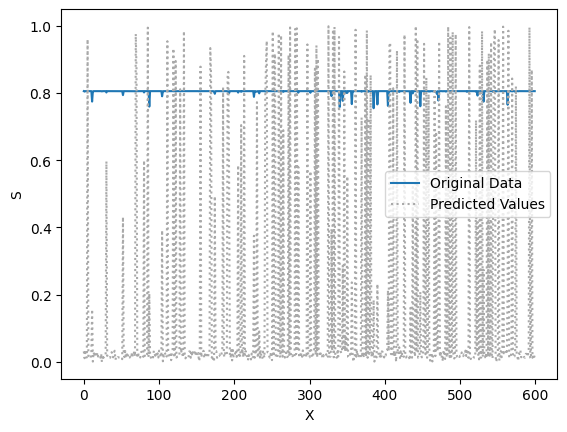

In [105]:
n_neurons = [6]
n_activation = [linear(1.2), tanh(1), linear(0.2)]

NN = Perceptron(2,n_neurons, 1, n_activation,0.1)
_ = NN.train(train_x, train_y,1)

import matplotlib.pyplot as plt

y_pred = [NN.forward(x)[0] for x in valid[:,0:-1]]
plt.plot(y_pred)
plt.plot(valid[:,-1], ":", color="darkgrey", )
plt.legend(["Original Data", "Predicted Values"])
plt.xlabel("X"); plt.ylabel("S")
plt.show()

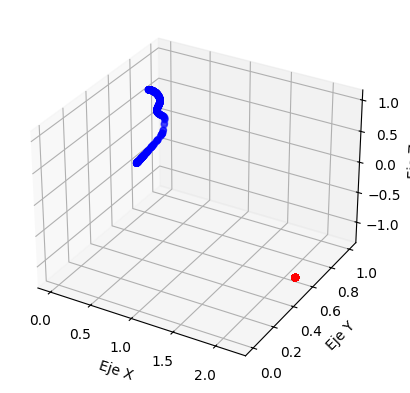

In [103]:
# Crear una figura 3D
fig = plt.figure()

# Agregar un subplot 3D
ax = fig.add_subplot(111, projection='3d')

# Crear un gráfico de dispersión en 3D
ax.scatter(y_pred,valid[:,0],valid[:,1], c='r', marker='o')
ax.scatter(valid[:,2], valid[:,0],valid[:,1], c='b', marker='o')

# Etiquetas de los ejes
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

# Mostrar el gráfico
plt.show()

# Segunda Manera de calcular el Bias

In [21]:
from MLP.dataManipulation import *
from MLP.activationFunctions import *
import numpy as np
import matplotlib.pyplot as plt

In [106]:
class Perceptron(object):
    def __init__(self,  num_inputs: int, num_neurons: list, num_outputs: int, func_activation: list, eta = 0.01) -> None:
        """ 
        Initializes the multi-layer perceptron with the specified architecture.

        Args:
        - num_inputs (int): Number of input features.
        - num_neurons (list of int): Number of neurons in each layer.
        - num_output (int): Number of output features.
        - func_activation (list): List of activation functions for each layer.

        """

        # Set the size of the network
        n_layers = [num_inputs] + num_neurons + [num_outputs]
        self.num_layers = len(n_layers)
        self.layers = [0]*self.num_layers
        self.num_neurons = n_layers
        

        # Define all of the layers
        input = num_inputs
        for i, neuron in enumerate(n_layers):
            self.layers[i] = Layer(input, neuron, func_activation[i], eta)
            input = neuron

    def forward(self, input: np.ndarray) -> np.ndarray:
        """
        Performs the forward pass through the neural network.

        Args:
        - input (array): The input data for the forward pass.

        Returns:
        - output (array): The output prediction of the neural network.

        """
        input = input.reshape(-1,1)
        # Iterate through all neurons
        for i in range(self.num_layers):
            input = self.layers[i].forward(input)

        self.output = input
        return self.output
    
    def backward(self, error: np.ndarray) -> list:
        """
        Performs the backward pass to update the network's weights.

        Args:
        - error (array): The error in the prediction.

        Returns:
        - gradients_prom (list of float): List of average gradients for each layer.

        """
        #Initializing an array for the mean of the gradients in every layer
        gradients = [0] * self.num_layers

        # Backpropagation for output layer
        gradients[-1] = self.layers[-1].backward(np.sum(error), 1, True)
        
        # Backpropagation for all the other layers
        for i in reversed(range(self.num_layers - 1)):
            gradients[i] = self.layers[i].backward(self.layers[i + 1].weights, gradients[i+1])

        return gradients

    def train(self, data_x: np.ndarray, data_y: np.ndarray, epochs: int) -> list:
        """
        Trains the neural network on the given data using backpropagation.

        Args:
        - data (array): Input data with the last value the target column.
        - epochs (int): Number of training epochs.

        Returns:
        - gradients (list): List of gradients computed during training.

        """

        # Defining the train and test set
        train_x, test_x, _, idx = train_test_val(data_x, (75,25,0))
        train_y = data_y[idx[0]]; test_y = data_y[idx[1]]
        print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

        # Check Y dimensions are of the size of the output layer
        assert len(train_y[0]) if type(train_y[0])==np.ndarray else 1 == self.num_neurons[-1]

        # Define auxiliary variables
        data_len = len(train_x)
        gradients = [0] * data_len * epochs
        instant_energy_train = [0] * data_len * epochs; instant_average_energy_test = [0]*epochs
        counter = 0

        for epoch in range(epochs):
            for i, stimuli in enumerate(train_x):
              y_pred = self.forward(np.array([stimuli]))
              error = np.array(train_y[i] - y_pred)

              instant_energy_train[counter] = np.sum(error**2)/2
              gradients[counter] = self.backward(error)
              counter += 1
              if  instant_energy_train[counter-1] < 0.01:  
                break
              
            #Test error
            error_test = np.array([test_y[i] - self.forward(x) for i,x in enumerate(test_x)])
            instant_average_energy_test[epoch] = np.mean(error_test**2)/2

            if instant_average_energy_test[epoch] < 0.01:
              break

        return gradients, instant_energy_train, instant_average_energy_test

class Layer():
    def __init__(self, num_inputs: int, num_neurons:int, activation: object, eta:float) -> None:
        """
        Initializes a neural network layer.

        Args:
        - n_inputs (int): Number of input features.
        - n_neurons (int): Number of neurons in the layer.
        - activation (Activation): Activation function for the layer.

        """

        # Initialize weights randomly (you can uncomment the random initialization below)
        self.weights = np.random.randn(num_neurons, num_inputs) *2 -1
        #self.weights = np.ones((num_neurons, num_inputs))

        # Initialize bias randomly (you can uncomment the random initialization below)
        #self.bias = np.random.randn(num_neurons, 1) * 2 - 1
        self.bias = np.ones((num_neurons, 1))
        self.weights = np.hstack((self.weights, self.bias))
        
        # Set Activation function
        self.activation = activation  # Create an instance of the provided activation function
        # Learning rate (you can adjust this)
        self.eta = eta

    def forward(self, input: np.ndarray) -> np.ndarray:
        """
        Performs the forward pass through the layer.

        Args:
        - input (array): The input stimuli for the layer.

        """

        # Save the input input for later use in backward pass
        self.input = input

        # Compute the initial linear combination of input and weights
        self.field = np.matmul(self.weights, np.vstack((self.input,1)))

        # Apply the activation function to the linear combination
        self.output = self.activation.forward(self.field)
        return self.output
    
    def backward(self, weights_prev: np.ndarray, local_gradient_prev: np.ndarray, first = False) -> np.ndarray:
        """
        Performs backpropagation for the layer.

        Args:
        - weights_prev (array): Weights from the next layer.
        - local_gradient_prev (array): Local gradient from the next layer.

        Returns:
        - local_gradient (array): Local gradient for this layer.

        """

        phi_prime = self.activation.backward(self.field)  # Compute the derivative of the activation function

        # Compute local gradient for this layer using chain rule and weights from the next layer
        local_gradient = np.multiply(phi_prime, np.dot(weights_prev[:,0:-1].T if not first else weights_prev, local_gradient_prev))

        # Compute weight update using the local gradient and input stimuli
        delta = np.dot(local_gradient, np.vstack((self.input,1)).T) # Weight and bias change
        assert delta.shape == self.weights.shape

        # Update weights using the learning rate and calculated delta
        weights_new = self.weights + self.eta * delta
        self.weights = weights_new

        return local_gradient

In [107]:
import scipy.io
mat = scipy.io.loadmat('../Trabajos/Trabajo_2/data/datosIA.mat')

data = np.column_stack([mat["X"], mat["OD"], mat["S"]])
data = normalize_min_max(data)

# X = [X, OD], Y = [S]
train, _, valid, idx = train_test_val(data, (80,0,20))
train_x = train[:,0:2]; train_y = train[:,2]

(1801, 2) (1801,) (600, 2) (600,)


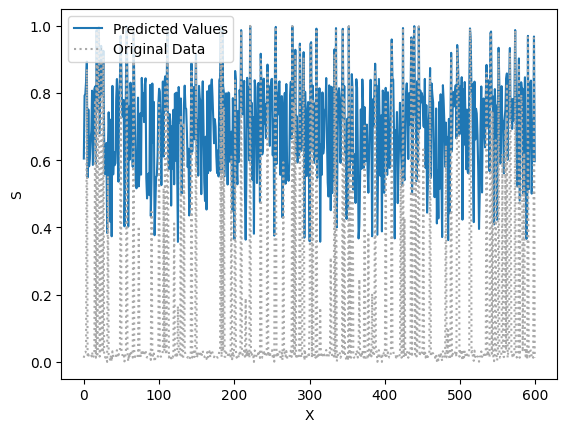

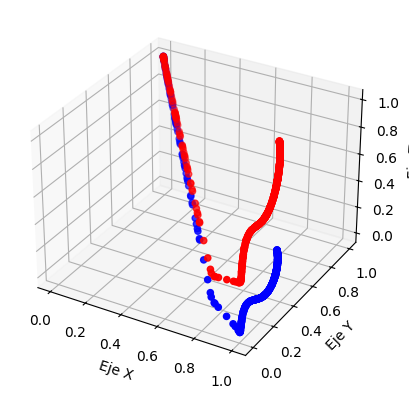

In [112]:

n_neurons = [5]
n_activation = [linear(1.2), linear(1), linear(0.2)]

NN = Perceptron(2,n_neurons, 1, n_activation,0.1)
_ = NN.train(train_x, train_y, 2)

import matplotlib.pyplot as plt

y_pred = [NN.forward(x)[0] for x in valid[:,0:-1]]
plt.plot(y_pred)
plt.plot(valid[:,-1], ":", color="darkgrey", )
plt.legend(["Predicted Values", "Original Data"])
plt.xlabel("X"); plt.ylabel("S")
plt.show()


# Crear una figura 3D
fig = plt.figure()

# Agregar un subplot 3D
ax = fig.add_subplot(111, projection='3d')

# Crear un gráfico de dispersión en 3D
ax.scatter(valid[:,0],valid[:,1], y_pred, c='r', marker='o', label="Predicted")
ax.scatter(valid[:,0],valid[:,1], valid[:,2], c='b', marker='o', label="Original")

# Etiquetas de los ejes
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

# Mostrar el gráfico
plt.show()